# Regrid UM OLR data

* Download UM OLR data
* Coarsen OLR
* Use easygems.remap to regrid from lat/lon to healpix
* Plot healpix vs orig lat/lon
* Heavily borrows from https://easy.gems.dkrz.de/Processing/datasets/remapping.html

In [1]:
# Download data if necessary.
from pathlib import Path
url = 'https://gws-access.jasmin.ac.uk/public/mcs_prime/wcrp_hackathon/20200101T0000Z_pa000.nc'
local_path = Path(url.split('/')[-1])

if not local_path.exists():
    import requests
    import shutil
    
    with requests.get(url, stream=True, auth=('wcrp_hackathon', 'letmeseeUMdata')) as r:
        with open(local_path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    download_file(url, local_path)
    print(f'Downloaded {url} to {local_path}')


In [2]:
import cartopy.crs as ccrs
import healpix as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import easygems.healpix as egh
import easygems.remap as egr

/home/users/mmuetz/miniforge3/envs/regrid2hp_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
ds = xr.open_dataset(local_path)
ds

<xarray.Dataset> Size: 79MB
Dimensions:                     (latitude: 3840, longitude: 5120, bnds: 2)
Coordinates:
  * latitude                    (latitude) float32 15kB -89.98 -89.93 ... 89.98
  * longitude                   (longitude) float32 20kB 0.03516 ... 360.0
    forecast_period             timedelta64[ns] 8B ...
    forecast_reference_time     datetime64[ns] 8B ...
    time                        datetime64[ns] 8B ...
Dimensions without coordinates: bnds
Data variables:
    toa_outgoing_longwave_flux  (latitude, longitude) float32 79MB ...
    latitude_longitude          int32 4B ...
    forecast_period_bnds        (bnds) float64 16B ...
    time_bnds                   (bnds) datetime64[ns] 16B ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.7
    Conventions:  CF-1.7

In [4]:
# I'm using pre-computed weights.

ds_coarse = ds
ds_coarse

<xarray.Dataset> Size: 79MB
Dimensions:                     (latitude: 3840, longitude: 5120, bnds: 2)
Coordinates:
  * latitude                    (latitude) float32 15kB -89.98 -89.93 ... 89.98
  * longitude                   (longitude) float32 20kB 0.03516 ... 360.0
    forecast_period             timedelta64[ns] 8B ...
    forecast_reference_time     datetime64[ns] 8B ...
    time                        datetime64[ns] 8B ...
Dimensions without coordinates: bnds
Data variables:
    toa_outgoing_longwave_flux  (latitude, longitude) float32 79MB ...
    latitude_longitude          int32 4B ...
    forecast_period_bnds        (bnds) float64 16B ...
    time_bnds                   (bnds) datetime64[ns] 16B ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.7
    Conventions:  CF-1.7

In [5]:
# Use trick from @flo on Mattermost.
# Pretty sure this is similar to:
# Lon, Lat = np.meshgrid(lon, lat)
# lon_flat = Lon.flatten()
# ...
ds_flat = ds_coarse.stack(cell=('longitude', 'latitude'))


In [10]:
order = zoom = 10
#nside = hp.order2nside(order)
#npix = hp.nside2npix(nside)

#hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
# Not needed for UM.
#hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
#hp_lon = hp_lon  % 360 # ensure the values are in [0, 360]
#hp_lon += 360 / (4 * nside) / 4  # shift quarter-width

In [11]:
# Slow for larger domain. Runs out of memory for me with full N2560 domain with 24G of RAM.
# Slowness mainly a function of input domain size I think, not healpix zoom level.
# weights = egr.compute_weights_delaunay((ds_flat.longitude.values, ds_flat.latitude.values), (hp_lon, hp_lat))
weights = xr.open_dataset('/gws/nopw/j04/hrcm/mmuetz/Lorenzo_u-cu087/OLR/regrid_weights_N2560_hpz10.nc')

In [12]:
olr_hp_z10 = egr.apply_weights(ds_flat.toa_outgoing_longwave_flux.values, **weights)

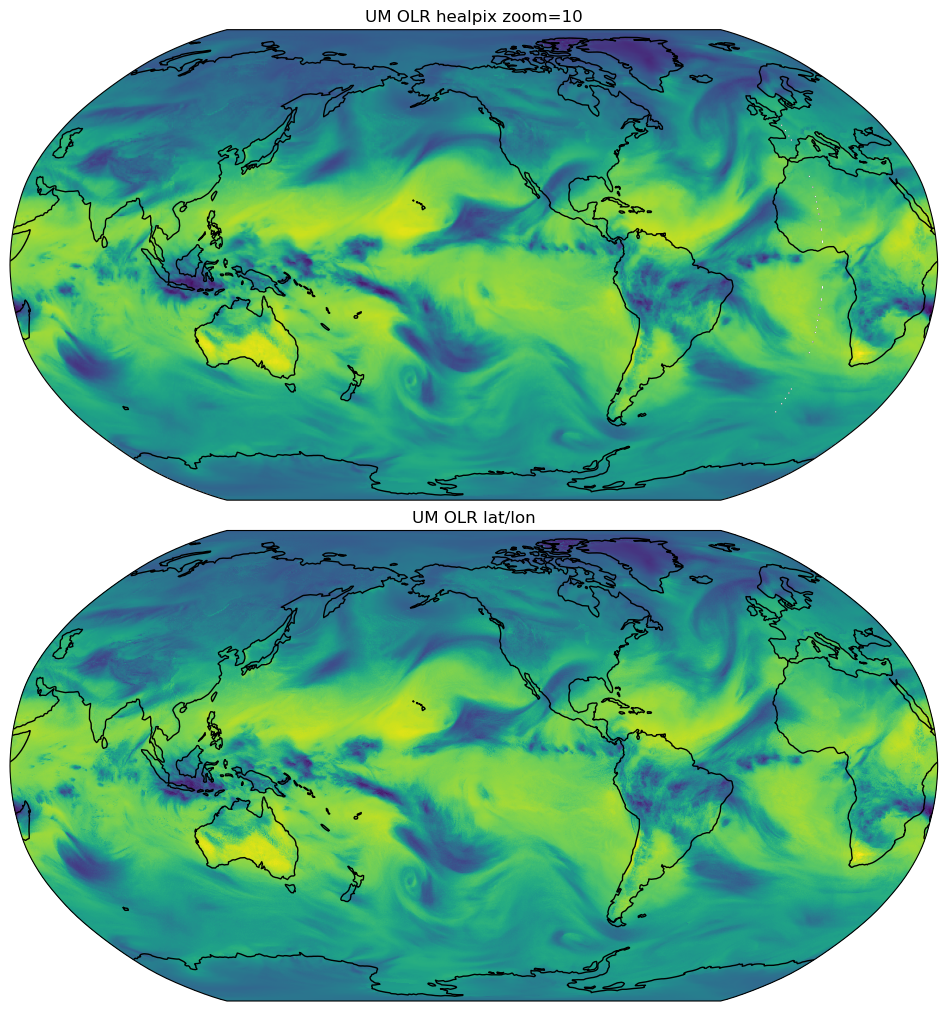

In [13]:
projection = ccrs.Robinson(central_longitude=-135.5808361)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': projection}, layout='constrained')
ax0.set_title(f'UM OLR healpix zoom={zoom}')
ax0.set_global()
egh.healpix_show(olr_hp_z10, ax=ax0);
ax0.coastlines()

ax1.set_title('UM OLR lat/lon')
ax1.pcolormesh(ds_coarse.longitude, ds_coarse.latitude, ds_coarse.toa_outgoing_longwave_flux, transform=ccrs.PlateCarree())
ax1.coastlines()

In [16]:
((hp_lon > 350) & (hp_lat < 10) & (hp_lat > -10)).sum()

0

(12582912,)
(3145728,)
(786432,)
(196608,)
(49152,)
(12288,)
(3072,)
(768,)
(192,)
(48,)
(12,)


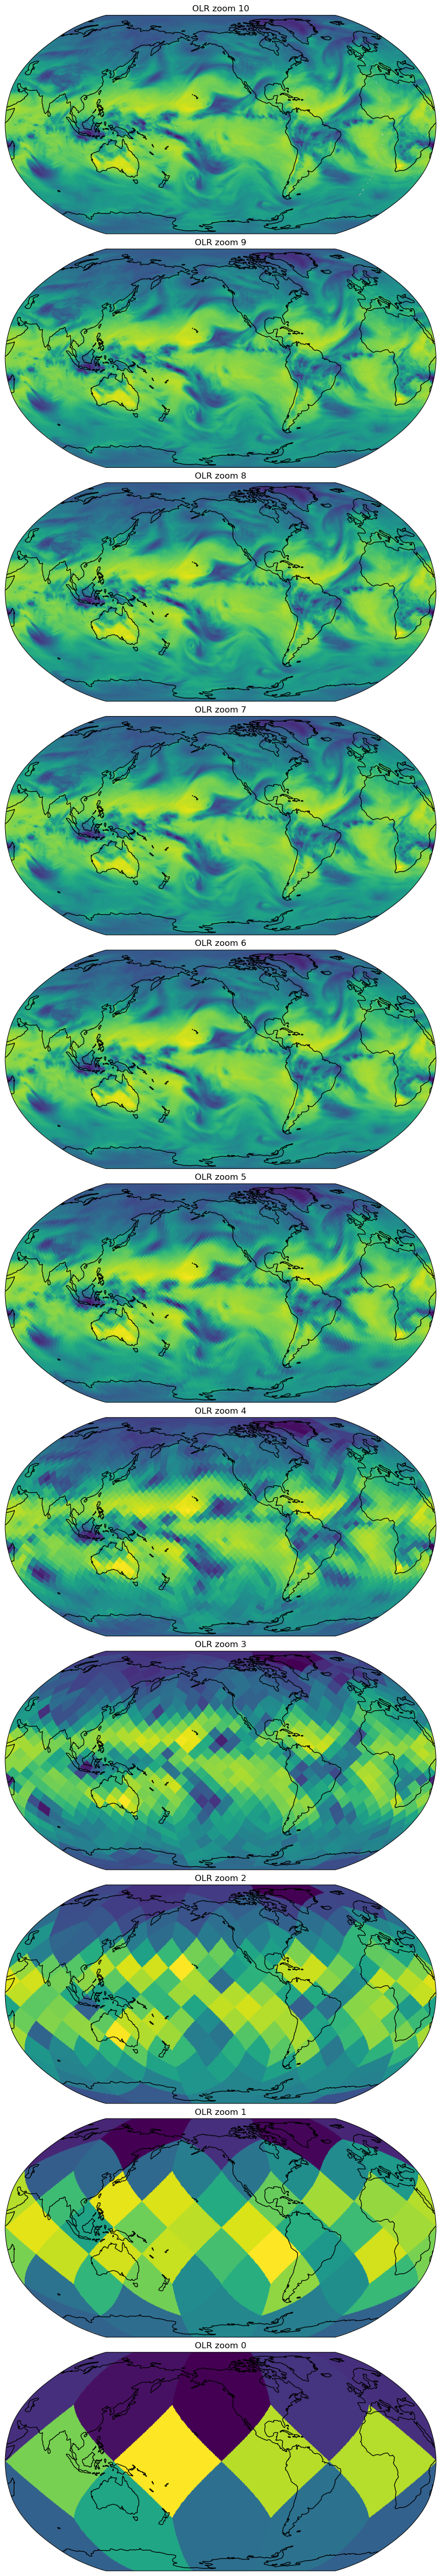

In [26]:
olr_hp_z = olr_hp_z5.copy()
fig, axes = plt.subplots(11, 1, figsize=(10, 50), subplot_kw={'projection': projection}, layout='constrained')


for ax, z in zip(axes, range(10, -1, -1)):
    print(olr_hp_z.shape)
    ax.set_global()
    egh.healpix_show(olr_hp_z, ax=ax);
    ax.coastlines()
    ax.set_title(f'OLR zoom {z}')
    
    olr_hp_z = np.nanmean(olr_hp_z.reshape(-1, 4), axis=1)

    

In [19]:
np.isnan(olr_hp_z5).sum()

2521